In [156]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from scipy.stats import norm
import heapq
import community as community_louvain

Part 1 : Graph loading & Rumor Propagation

```
# This is formatted as code
```



In [157]:
seed =1 # this is for same structure for the graph

In [158]:
import networkx as nx
import os

def read_graph(file_path):
    """
    Read an undirected graph from .mtx, .edges, or .txt file formats.
    """
    G = nx.Graph()
    file_ext = os.path.splitext(file_path)[1].lower()

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or line.startswith('%'):  # Skip comments or empty lines
                continue

            parts = line.split()
            if len(parts) < 2:
                continue

            # Convert nodes to int
            u, v = map(int, parts[:2])

            # If .mtx file, Matrix Market format is 1-based indexing
            if file_ext == '.mtx':
                G.add_edge(u - 1, v - 1)  # Convert to 0-based indexing
            else:
                G.add_edge(u, v)

    return G


In [159]:
# ------------------ Rumor Propagation --------------------
def propagate_rumor(G, mu=2, sigma=1, stop_fraction=0.5):
    """Simulate rumor spread with Gaussian transmission delays"""
    source = random.choice(list(G.nodes()))
    propagation_time = {source: 0}
    infected = set([source])
    heap = [(0, source)]

    while heap and (len(infected) < stop_fraction * len(G)):
        t_u, u = heapq.heappop(heap)

        for v in G.neighbors(u):
            if v not in propagation_time:
                theta_uv = max(0.1, np.random.normal(mu, sigma))
                t_v = t_u + theta_uv
                propagation_time[v] = t_v
                infected.add(v)
                heapq.heappush(heap, (t_v, v))

    return infected, source, propagation_time

In [160]:
# ------------------ Visualization ------------------------
def visualize_propagation(G, infected, source):
    pos = nx.spring_layout(G)
    node_colors = ['red' if n == source else
                  'orange' if n in infected else
                  'blue' for n in G.nodes()]

    plt.figure(figsize=(10,7))
    nx.draw(G, pos, node_color=node_colors, node_size=100,
           edge_color='gray', with_labels=True)
    plt.title("Rumor Propagation State")
    plt.show()

In [161]:
import networkx as nx
import matplotlib.pyplot as plt

def show_graph_details(G):
    """Print detailed summary of the graph G and optionally plot it if small."""
    print("Graph Summary")
    print("-------------")
    print(f"Type: {'Directed' if G.is_directed() else 'Undirected'}")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    degrees = [deg for node, deg in G.degree()]
    if degrees:
        print(f"Min degree: {min(degrees)}")
        print(f"Max degree: {max(degrees)}")
        print(f"Average degree: {sum(degrees)/len(degrees):.2f}")

    try:
        if nx.is_connected(G.to_undirected()):
            print("Connected: Yes")
        else:
            print("Connected: No")
            num_components = nx.number_connected_components(G.to_undirected())
            print(f"Number of connected components: {num_components}")
    except nx.exception.NetworkXError:
        print("Connected: Not applicable (possibly a directed graph)")

    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

    print("\nSample Nodes (up to 5):")
    print(list(G.nodes())[:5])

    print("\nSample Edges (up to 5):")
    print(list(G.edges())[:5])

    # Plot if the graph is small
    if G.number_of_nodes() <= 100:
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_color='skyblue', edge_color='gray', with_labels=True, node_size=500, font_size=8)
        plt.title("Graph Visualization")
        plt.axis('off')
        plt.show()
    else:
        print("\nGraph too large to visualize (>100 nodes).")


Graph Summary
-------------
Type: Undirected
Number of nodes: 62
Number of edges: 160
Min degree: 1
Max degree: 12
Average degree: 5.16
Connected: Yes
Average clustering coefficient: 0.2590

Sample Nodes (up to 5):
[61, 10, 0, 14, 15]

Sample Edges (up to 5):
[(61, 61), (61, 2), (61, 37), (61, 53), (10, 0)]


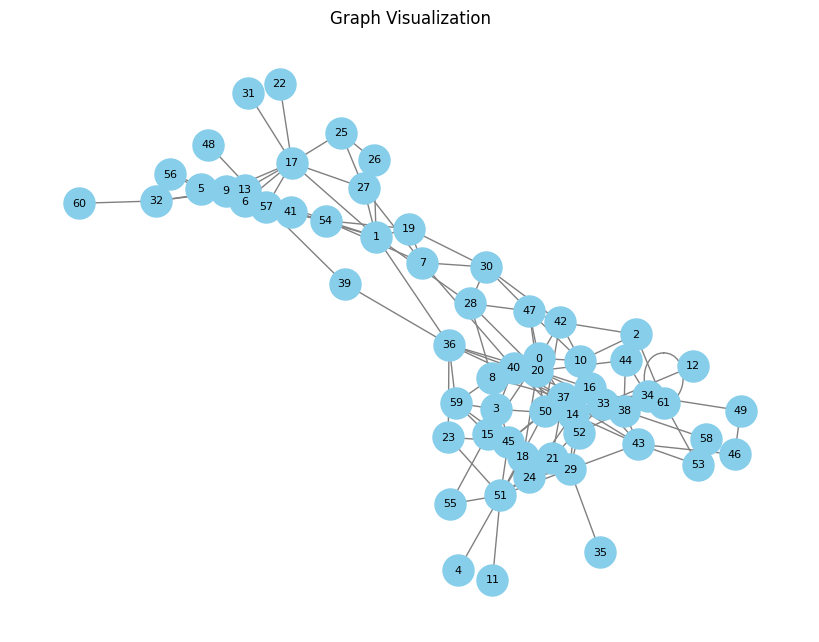

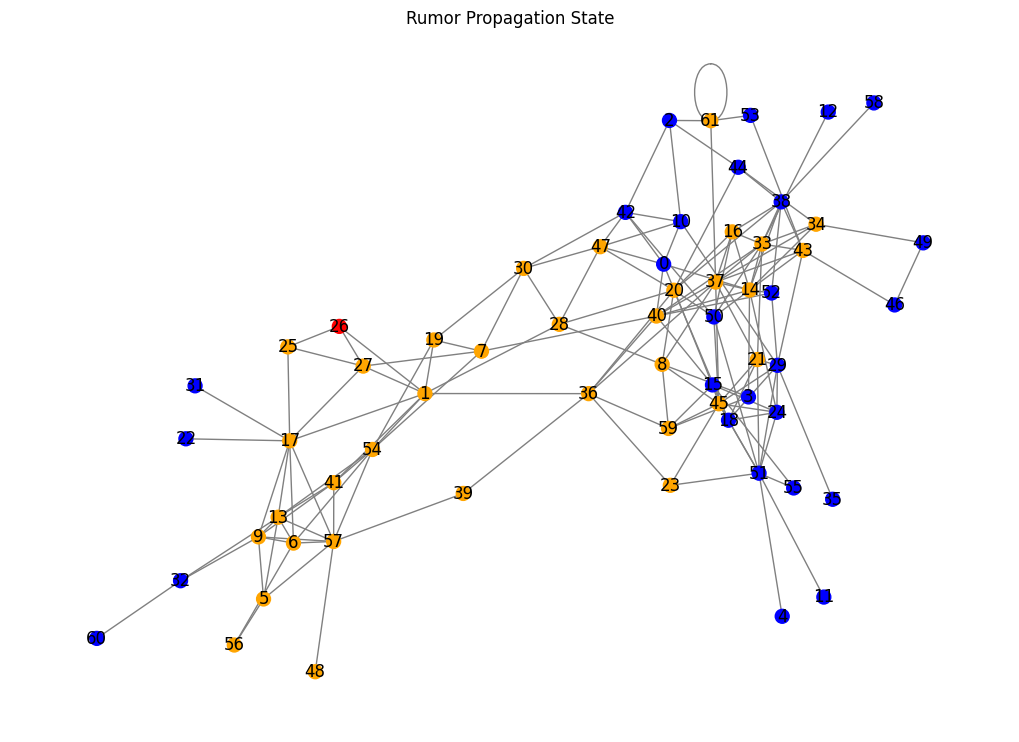

In [162]:
# ------------------- Main Execution ----------------------
if __name__ == "__main__":
    # Load network
    G = read_graph("/content/dolphins.mtx")  # Replace with your dataset
    # Added later..
    show_graph_details(G)


    # Simulate rumor spread
    infected, true_source, propagation_time = propagate_rumor(G)
    visualize_propagation(G, infected, true_source)

Part 2: Observer Deployment

In [163]:
# ------------------ Observer Deployment ------------------
def deploy_observers(G, infected, propagation_time, num_observers=15):
    """Strategic observer placement combining community structure and temporal information"""
    # import community as community_louvain
    partition = community_louvain.best_partition(G)

    observers = set()

    # Phase 1: Core nodes per community
    community_cores = []
    for comm in set(partition.values()):
        candidates = [n for n in partition if partition[n] == comm and n in infected]
        if candidates:
            core_node = max(candidates, key=lambda x: (G.degree(x), -propagation_time[x]))
            community_cores.append(core_node)

    observers.update(community_cores)

    # Phase 2: Temporal supplement
    remaining = num_observers - len(observers)
    if remaining > 0:
        time_sorted = sorted((t for t in propagation_time.items() if t[0] in infected),
                            key=lambda x: x[1])[:2*num_observers]
        observers.update([n for n, _ in time_sorted[:remaining]])

    return observers, {o: propagation_time[o] for o in observers}

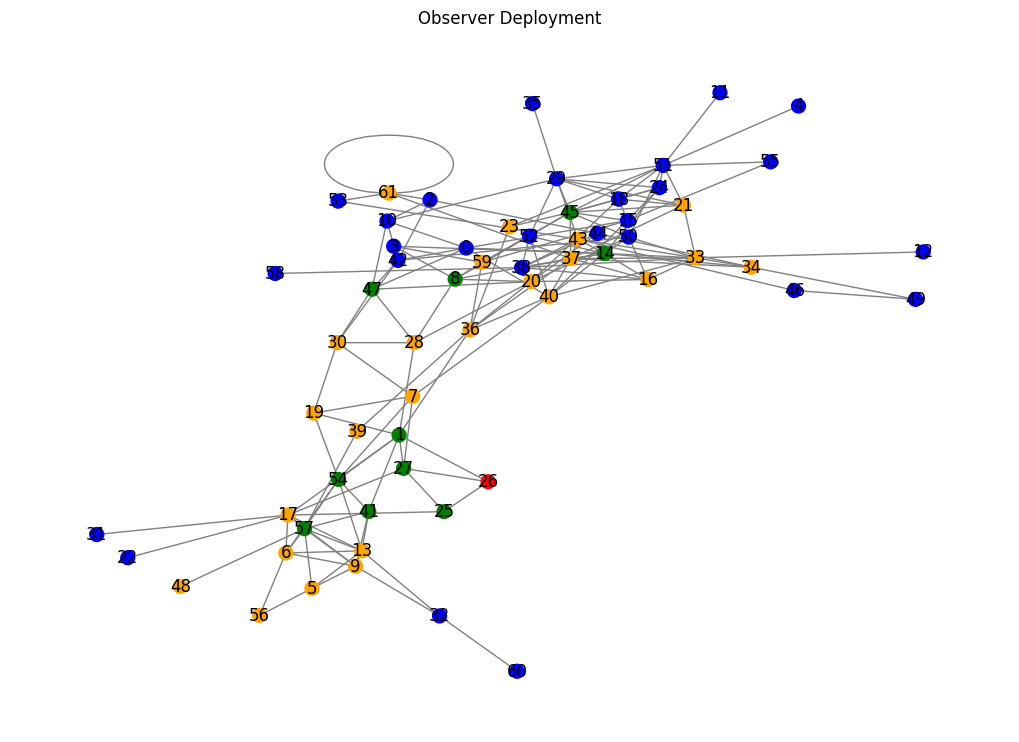

In [164]:
def visualize_observers(G, observers, infected, source):
    pos = nx.spring_layout(G)
    node_colors = []
    for n in G.nodes():
        if n == source:
            node_colors.append('red')
        elif n in observers:
            node_colors.append('green')
        elif n in infected:
            node_colors.append('orange')
        else:
            node_colors.append('blue')

    plt.figure(figsize=(10,7))
    nx.draw(G, pos, node_color=node_colors, node_size=100,
           edge_color='gray', with_labels=True)
    plt.title("Observer Deployment")
    plt.show()

  # Deploy observers (adaptive count: 20% of nodes or max 20)
num_observers = min(int(len(G.nodes())*0.2), 20)
observers, _ = deploy_observers(G, infected, propagation_time, num_observers)
visualize_observers(G, observers, infected, true_source)

Network Reconstruction

In [165]:
def reconstruct_network(propagation_time, G):
    """Create directed diffusion network based on infection times"""
    directed_G = nx.DiGraph()

    for u, v in G.edges():
        t_u = propagation_time.get(u, float('inf'))
        t_v = propagation_time.get(v, float('inf'))

        if t_u < t_v:
            directed_G.add_edge(u, v)
        elif t_v < t_u:
            directed_G.add_edge(v, u)

    return directed_G

In [166]:
def visualize_reconstructed(directed_G, propagation_time, source_node):
    pos = nx.spring_layout(directed_G)

    node_colors = []
    for n in directed_G.nodes():
        if n == source_node:
            node_colors.append('red')  # highlight source
        elif n in propagation_time:
            node_colors.append('orange')  # infected
        else:
            node_colors.append('blue')  # uninfected

    plt.figure(figsize=(10, 7))
    nx.draw(directed_G, pos, node_color=node_colors, node_size=100,
            edge_color='gray', arrows=True, with_labels=True)
    plt.title("Reconstructed Diffusion Network")
    plt.show()

In [167]:
directed_G = reconstruct_network(propagation_time, G)
#visualize_reconstructed(directed_G, propagation_time, true_source)

Source Localization

In [168]:
# ----------------- Source Localization -------------------
def localize_source(G, observers, propagation_time):
    """Hybrid localization using temporal and structural features"""
    valid_observers = [o for o in observers if o in propagation_time]
    if not valid_observers:
        return None

    obs_times = np.array([propagation_time[o] for o in valid_observers])
    scores = {}

    for node, t_source in propagation_time.items():
        # Temporal constraints
        time_diffs = t_source - obs_times
        valid_diffs = time_diffs[np.isfinite(time_diffs)]

        if len(valid_diffs) < 3:
            continue  # Require minimum 3 observations

        # Temporal likelihood
        temporal_score = norm.pdf(valid_diffs,
                                loc=np.mean(valid_diffs),
                                scale=np.std(valid_diffs)+1e-6).mean()

        # Structural features
        try:
            # Get centrality for the specific node only
            centrality = nx.current_flow_closeness_centrality(G, node=node)
        except:
            # If the above fails, use degree centrality for the specific node
            centrality = nx.degree_centrality(G).get(node, 0)

        # Penalize impossible temporal relationships
        inconsistency_penalty = sum(1 for d in valid_diffs if d > 0) * 10

        scores[node] = (temporal_score * 0.6 +
                       centrality * 0.4 -
                       inconsistency_penalty)

    return max(scores, key=scores.get) if scores else None

In [169]:
def visualize_results(G, true_source, estimated_source, observers, infected):
    pos = nx.spring_layout(G)
    node_colors = []
    node_sizes = []

    for n in G.nodes():
        if true_source == estimated_source and n == true_source:
            node_colors.append('deeppink')  # special color when both are same
            node_sizes.append(300)         # larger size for emphasis
        elif n == true_source:
            node_colors.append('red')
            node_sizes.append(100)
        elif n == estimated_source:
            node_colors.append('purple')
            node_sizes.append(100)
        elif n in observers:
            node_colors.append('green')
            node_sizes.append(100)
        elif n in infected:
            node_colors.append('orange')
            node_sizes.append(100)
        else:
            node_colors.append('blue')
            node_sizes.append(100)

    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes,
            edge_color='gray', with_labels=True)

    legend_elements = []

    if true_source == estimated_source:
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w', label='True = Estimated',
                       markerfacecolor='deeppink', markersize=10)
        )
    else:
        legend_elements.extend([
            plt.Line2D([0], [0], marker='o', color='w', label='True Source',
                       markerfacecolor='red', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Estimated',
                       markerfacecolor='purple', markersize=10),
        ])

    legend_elements.extend([
        plt.Line2D([0], [0], marker='o', color='w', label='Observers',
                   markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Infected',
                   markerfacecolor='orange', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Susceptible',
                   markerfacecolor='blue', markersize=10)
    ])

    plt.legend(handles=legend_elements, loc='best')
    plt.title("Source Localization Result")
    plt.show()


In [170]:
# Localize source
estimated_source = localize_source(G, observers, propagation_time)
# Show final results
#visualize_results(G, true_source, estimated_source, observers, infected)
print(f"True Source: {true_source} | Estimated Source: {estimated_source}")
print(f"Localization {'Success' if true_source == estimated_source else 'Failure'}")

True Source: 26 | Estimated Source: 26
Localization Success


Observer Ratio | Accuracy   | Avg Error Distance (Δ) | Avg Error Hops
---------------|------------|------------------------|----------------
0.01           | 0.2100     | 1.0700                 | 1.0700
0.02           | 0.0900     | 1.2750                 | 1.2750
0.03           | 0.1150     | 1.3000                 | 1.3000
0.04           | 0.1700     | 1.1300                 | 1.1300
0.05           | 0.1850     | 1.1550                 | 1.1550
0.08           | 0.2100     | 1.0750                 | 1.0750
0.1            | 0.9950     | 0.0100                 | 0.0100
0.2            | 1.0000     | 0.0000                 | 0.0000


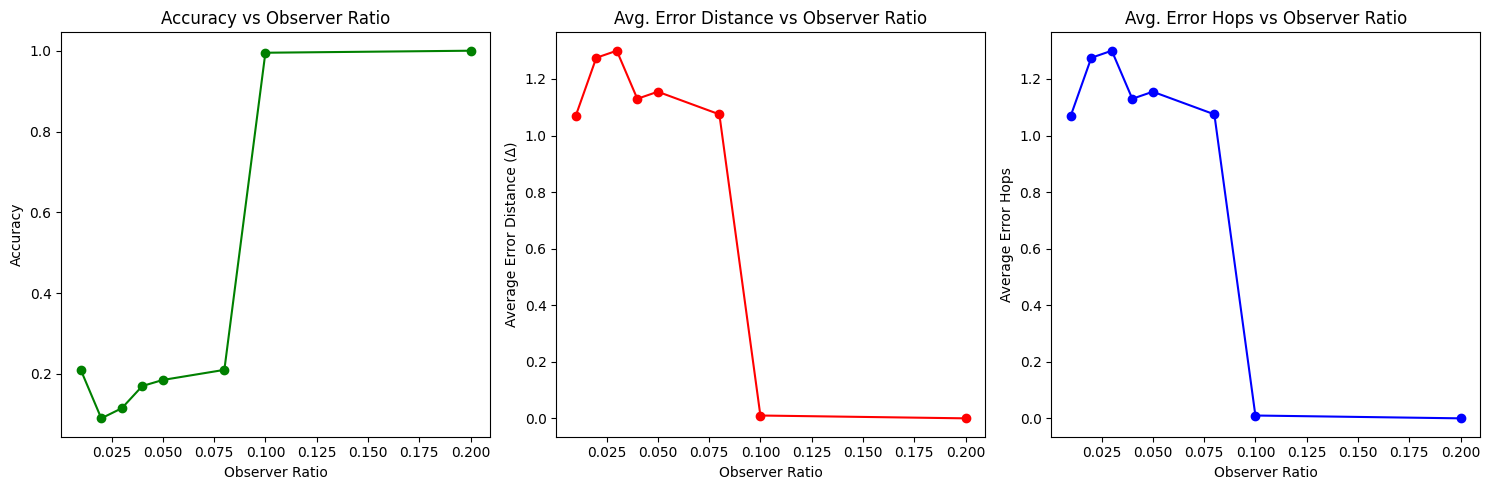

In [172]:
import networkx as nx
import matplotlib.pyplot as plt

def evaluate_localization_for_ratio(G, observer_ratio=0.2, iterations=200):
    count_correct = 0
    total_distance = 0
    hop_errors = []

    for _ in range(iterations):
        infected, true_source, propagation_time = propagate_rumor(G)

        # Vary number of observers as a percentage of nodes
        num_observers = max(1, int(len(G.nodes()) * observer_ratio))
        observers, _ = deploy_observers(G, infected, propagation_time, num_observers)

        directed_G = reconstruct_network(propagation_time, G)
        estimated_source = localize_source(G, observers, propagation_time)

        # Accuracy
        if estimated_source == true_source:
            count_correct += 1

        # Error distance
        dist = nx.shortest_path_length(G, source=estimated_source, target=true_source)
        total_distance += dist
        hop_errors.append(dist)

    accuracy = count_correct / iterations
    avg_error_distance = total_distance / iterations
    avg_error_hops = sum(hop_errors) / iterations

    return accuracy, avg_error_distance, avg_error_hops


# Observer ratios to test
ratios = [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2]
results = []

print("Observer Ratio | Accuracy   | Avg Error Distance (Δ) | Avg Error Hops")
print("---------------|------------|------------------------|----------------")

for r in ratios:
    accuracy, delta, hops = evaluate_localization_for_ratio(G, observer_ratio=r)
    results.append((r, accuracy, delta, hops))
    print(f"{r:<14} | {accuracy:<10.4f} | {delta:<22.4f} | {hops:.4f}")

# Plotting
ratios, accuracies, deltas, hop_counts = zip(*results)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(ratios, accuracies, marker='o', color='green')
plt.title("Accuracy vs Observer Ratio")
plt.xlabel("Observer Ratio")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 2)
plt.plot(ratios, deltas, marker='o', color='red')
plt.title("Avg. Error Distance vs Observer Ratio")
plt.xlabel("Observer Ratio")
plt.ylabel("Average Error Distance (Δ)")

plt.subplot(1, 3, 3)
plt.plot(ratios, hop_counts, marker='o', color='blue')
plt.title("Avg. Error Hops vs Observer Ratio")
plt.xlabel("Observer Ratio")
plt.ylabel("Average Error Hops")

plt.tight_layout()
plt.show()
